<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2024notebooks/2023_1114Stroop_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroop effect

# 文献

* J. Ridley Stroop (1935) [STUDIES OF INTERFERENCE IN SERIAL VERBAL REACTIONS](https://psychclassics.yorku.ca/Stroop/), Journal of Experimental Psychology, 18, 643-662.

<center>
<div style="width:88%;font-color:teal;">

語の名前と異なる色で印刷された色名語音読 (RCNd) 条件 (100 刺激，単位:秒) と黒インクで印字された色名語音読条件 (RCNb)<br/>
**RCNd** 印刷色が文字と不一致の場合の色名文字音読条件，
**RCNb** 黒インクで印字された色名文字音読条件，
**No. Ss** 被験者数，**s** 標準偏差，**D** 差分，**D/PEd** 差分を確率誤差で除した値<br/>
Stroop (1935) Table 1.
</div>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/1935Stroop_tab1.jpg" style="width:77%">
<!-- <img src="1935Stroop_tab1.jpg" width="77%"> -->
<div style="width:88%;font-color:teal;">

正方形 ■ の色名呼称条件と，他の色で印刷された語の色名音読条件<br/>
**NCWd**: 色名呼称時に文字が色と異なる条件，**NC** 色名呼称条件.
Stroop (1935) Table 3.    
</div>    

<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/1935Stroop_tab3.jpg" style="width:77%">
<!-- <img src="1935Stroop_tab3.jpg" width="77%">-->
</center>

* **NC**: 色名呼称 Naming Colors.
* **NCWd**: 色名呼称時に文字が色と異なる場合 Naming the Colors of the Print of Words Where the Color of the Print and the Word are Different.
* **RCNb** 黒で書かれた色名を読む Reading Color Names Printed in Black Ink.
* **RCNd** 色名を読むが，印刷色と単語名が不一致 Reading Color Names Where the Color of the Print and the Word are Different.
* **D** 差分 Difference.
* **D/P Ed** 差分を確率誤差で除した値 Difference divided by the probable error of the difference.
* **M & F** 男性と女性 Males and Females.
* **P Ed**: 差分の確率誤差 Probable error of the difference.
* **s**: 標準偏差 Sigma or standard deviation.
* **s / m**:  Standard deviation divided by the mean.


<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2003Roelofs_stroop_fig9.jpg" style="width:44%">
<!-- <img src="2003Roelofs_stroop_fig9.jpg" width="44%"><br/>-->
</center>    
<div style="width:77%;background-color:lavendar;">

Stroop 課題における，単語計画と実行制御。
ヒトの左半球の側面図 (上) と 中央 (下)。
単語計画系は，色知覚 (cp)，概念同定 (ci)，レンマ検索 (lr)，単語携帯符号化 (wfe)，構音処理 (art) を
介して色名呼称へと至る。
単語形態知覚 (wfp) は，語彙と形態と並列的に至る。
単語音読は，最小限 wfp, wfe, art を含む。
実行系は前帯状回にあり，目標と入力制御に関与する。
<!-- Figure 9. Word planning and executive control in the Stroop task.
Lateral view (top panel) and medial view (bottom panel) of the left hemisphere of the human brain.

The word-planning system achieves color naming through color perception (cp), conceptual identification (ci), lemma retrieval (lr), word-form encoding (wfe), and articulatory processing (art); word-form perception (wfp) activates lemmas and word forms in parallel.
Word reading minimally involves wfp, wfe, and art.
The executive system centered on the anterior cingulate achieves goal and input control. -->
出典: Roelofs (2003) __Goal-Referenced Selection of Verbal Action: Modeling Attentional Control in the Stroop Task__, Psychological Review, 2003, Vol. 110, No. 1, 88–125.
</div>
</center>    

# 下準備

## ライブラリの輸入

In [ ]:
%config InlineBackend.figure_format = 'retina'
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

if isColab:
    !pip install --upgrade termcolor==1.1
from termcolor import colored

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade
    !git clone https://github.com/ShinAsakawa/bit.git
    import bit

import os
HOME = os.environ['HOME']

from tqdm.notebook import tqdm

## 乱数系列発生器の種を設定

In [2]:
# 乱数のシードを設定
import numpy as np
import random
import sys

seed=42
torch.manual_seed(seed=seed)
np.random.seed(seed=seed)
random.seed(seed)
batch_size = 128

# 1 データセットの定義

In [3]:
from bit import get_text_img
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from glob import  glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms import v2

class stroop_Dataset(Dataset):
    def __init__(self,
                 dataset_name:str='train'):

        super().__init__()
        self.dataset_name = 'train' if dataset_name == 'train' else 'val'

        self.width, self.height = 224, 224
        self.bgcolor = (255,255,255)

        # 色刺激情報
        self.colors = ['black', 'red', 'green', 'blue', 'yellow']

        # 文字刺激情報，上の色刺激情報と一対一対応
        self.words  = ['黒', '赤', '緑', '青', '黄','■']

        # 認識の一般性を確保するために複数の文字サイズを用いる
        self.font_sizes=[42, 56, 70, 84, 98, 112]

        # 認識の一般性を確保するために複数の文字フォントを用いる
        # 無料で公開されている Noto フォントを用いる。
        # 下のループを実行することで 14 種類のフォントが登録される
        # NotoSerif は明朝体，NotoSans はゴチック体と考えれば良い
        # これら両書体について，各々 7 種類の太さが定義されている
        fonts = []
        for font_size in self.font_sizes:
            _fonts = bit.get_notojp_fonts(fontsize=font_size, verbose=False)
            for _fontname, _font in _fonts.items():
                font_name = str(f'{font_size:03d}')+_fontname

                if dataset_name == 'train':
                    fonts.append((font_name, _font))
                elif 'Regular' in _fontname:
                    fonts.append((font_name, _font))

        self.fonts = fonts

        # 上記の，文字 X 色 X サイズ X フォント で条件を作成
        # 文字呼称条件と色名呼称条件とが Stroop 効果である。
        # 理論上，サイズ同定条件，フォント識別問題でも同様の実験が成り立つが今回は採用せず
        cond = []
        for font in fonts:
            size = int(font[0][:3])
            for color in self.colors:
                for word in self.words:
                    # 条件は (色，文字，フォントサイズ，フォント書体) の 4 連 tuple
                    cond.append((color, word, size, font))
        self.cond = cond

        #self.affine = v2.RandomAffine(degrees=(-2, 2), translate=(0.1, 0.1), fill=1)
        self.affine = v2.RandomAffine(degrees=(-5, 5), translate=(0.15, 0.15), fill=1)

    def __len__(self):
        return len(self.colors) * len(self.words) * len(self.fonts)
        #return len(self.cond)

    def __getitem__(self, idx:int):

        color_ = self.cond[idx][0]
        word_  = self.cond[idx][1]
        size_  = self.cond[idx][2]
        font_name  = self.cond[idx][3][0]
        font_  = self.cond[idx][3][1]

        color_idx = self.colors.index(color_)
        word_idx  = self.words.index(word_)
        size_idx  = self.font_sizes.index(size_)

        # 条件に従った画像を 1 枚生成
        img, draw_canvas, bbox = get_text_img(
            text=word_, color=color_, draw_bbox=False, font=font_)

        # 画像を torch.Tensor に変換しないと，DataLoader でハンドリングできない。
        # このため一旦 torch.tensor に変換している
        _img = torch.tensor(
            (np.array(img)/255).clip(0,1).transpose(2,0,1),
            device=device,
            dtype=torch.float32,
        )

        if self.dataset_name == 'train':
            _img = self.affine(_img)

        return _img, {'color':self.colors.index(color_),
                     'word':self.words.index(word_),
                     'font_size':size_, 'font_name':font_name}

stroop_ds = stroop_Dataset()
stroop_val_ds = stroop_Dataset(dataset_name='val')

## 定義したデータセットの視覚化

In [ ]:
fig, ax = plt.subplots(6, 6, figsize=(14, 10))
i, j = 0, 0
j_max = 6

ds = stroop_ds # or stroop_val_ds
#ds = stroop_val_ds
Ns = np.random.permutation(ds.__len__())
for idx in Ns[:36]:
#for idx in range(30):
    img, y = ds.__getitem__(idx)
    _img = img.detach().squeeze(0).cpu().numpy().transpose(1,2,0) # * 255
    #print(_img.max(), _img.min())
    #print(idx,y)
    ax[i,j].imshow(_img)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    j += 1
    if j == j_max:
        i+=1; j=0

#plt.show()

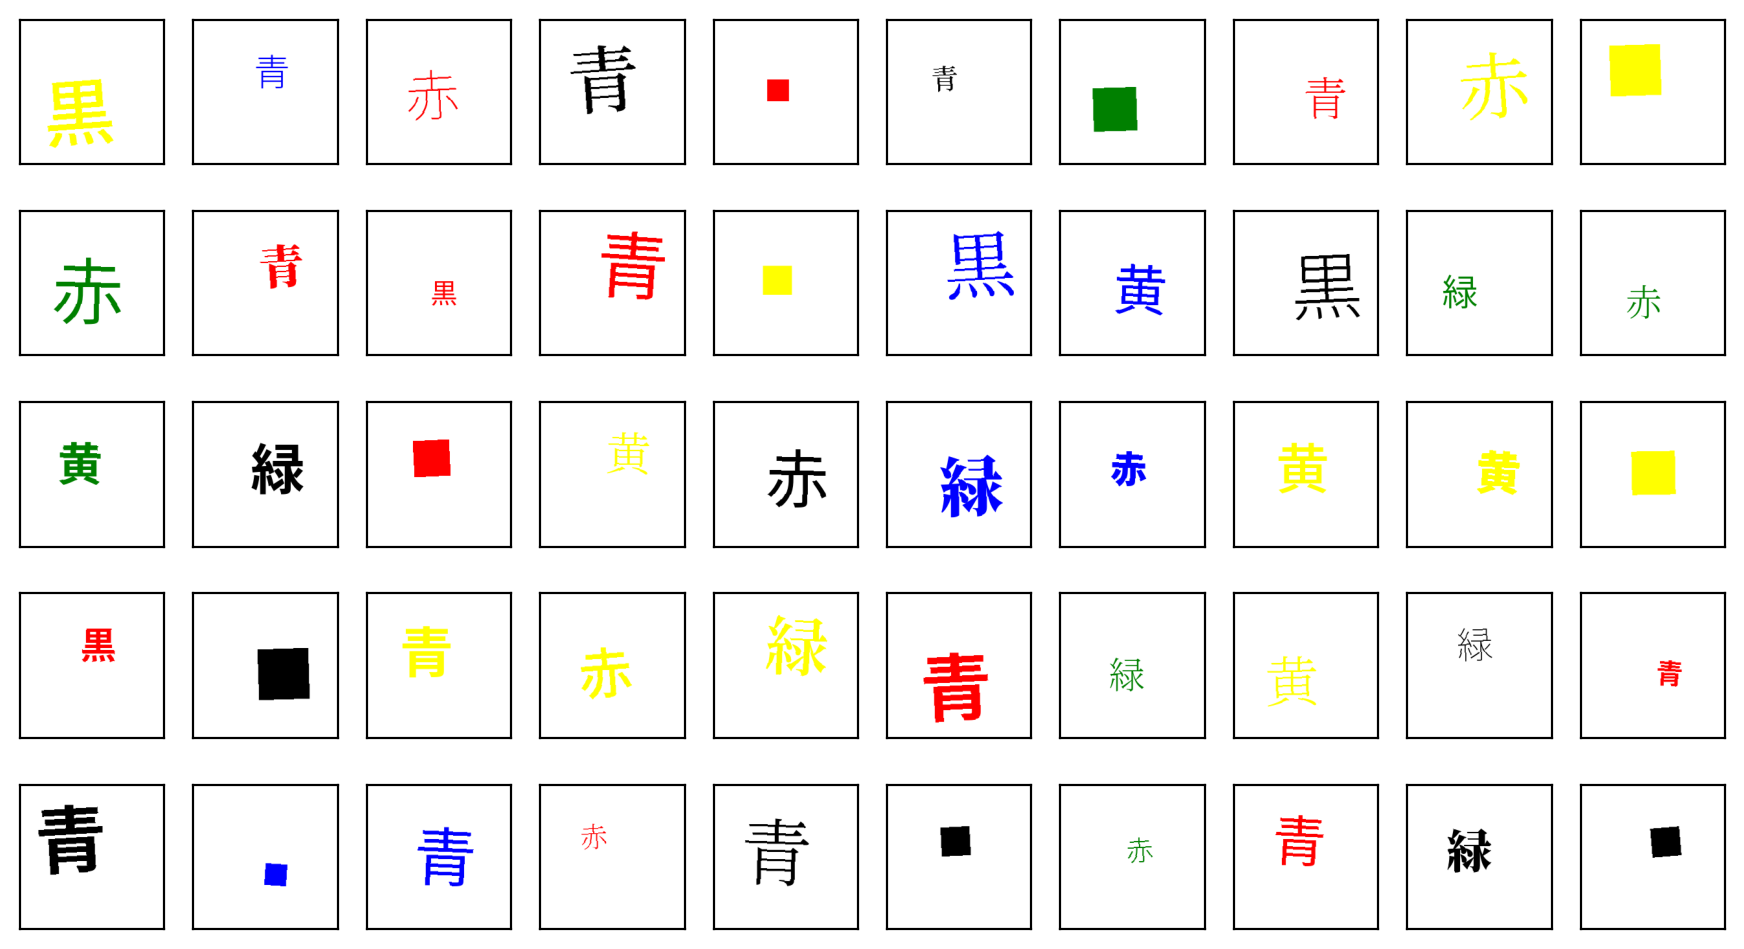

In [6]:
j_max = 10
i_max = 5
Ns = np.random.permutation(ds.__len__())
fig, ax = plt.subplots(i_max, j_max, figsize=(j_max+1,i_max+1))
i, j = 0, 0
for idx in Ns[:i_max * j_max]:
    img, y = ds.__getitem__(idx)
    img = img.detach().squeeze(0).cpu().numpy().transpose(1,2,0) # * 255

    ax[i,j].imshow(img)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    j += 1
    if j == j_max:
        i+=1; j=0

plt.show()

## 訓練用，検証用データへの分割とデータローダ用意

In [7]:
train_ds = stroop_ds
val_ds = stroop_val_ds

# 並列計算のために collation 関数を定義
def _collate_fn(batch):
    inps, tgts = list(zip(*batch))
    inps = list(inps)
    tgts = list(tgts)
    return inps, tgts

# 訓練データセット用データローダ
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=_collate_fn
)

# 検証データセット用データローダ
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=_collate_fn
)

# 後に使用するために，データローダに名前を加えておく
train_dl.name = 'train'
val_dl.name = 'val'

## 公開されている訓練済一般画像認識 (ImageNet) モデルの読み込み，最終層の付け替え

In [ ]:
# 各モデルを定義し，訓練済み結合係数をダウンロード
import copy
import torchvision
from torchvision import models

#model = models.efficientnet_v2_m(weights="DEFAULT")
#model = models.efficientnet_v2_s(weights="DEFAULT")
model = models.resnet18(weights="DEFAULT")

# print(str(type(model.eval())))
# print(type(model.features))
# print(model.classifier)

for n, p in model.named_buffers():
#for n, p in model.features.named_buffers():
    print(n, p.size())
# for param in model.classifier.parameters():
#     print(type(param), param.size())

$$
\text{Hardswish}(x) =
\begin{cases}
          0 & \text{if~} x \le -3, \\
          x & \text{if~} x \ge +3, \\
          x \cdot (x + 3) /6 & \text{otherwise}
\end{cases}
$$

In [ ]:
#model.eval()
# for param in model.layer4.parameters():
# #for name, param in model.layer4.named_buffers():
#     print(param.data.size())

for param_ in [model.fc.parameters(), model.layer4.parameters()]:
    for param in param_:
        print(param.size(), type(param))

#print(type(model.fc.parameters()))

for name, param in model.layer4.named_parameters():
    print(name, type(param))

In [9]:
# 各モデルを定義し，訓練済み結合係数をダウンロード
import copy
import torchvision
from torchvision import models

#cnn_col = models.resnet50(weights="DEFAULT")
#cnn_wrd = models.resnet50(weights="DEFAULT")
cnn_col = models.resnet18(weights="DEFAULT")
cnn_wrd = models.resnet18(weights="DEFAULT")
#cnn_col = models.efficientnet_v2_s(weights="DEFAULT")
#cnn_wrd = models.efficientnet_v2_s(weights="DEFAULT")
# cnn_col = torchvision.models.mobilenet_v3_small(weight="DEFAULT")
# cnn_wrd = torchvision.models.mobilenet_v3_small(weight="DEFAULT")

parameters_col = {name:param for name, param in cnn_col.named_parameters()}
modules_col = {name:param for name, param in cnn_col.named_modules()}
parameters_wrd = {name:param for name, param in cnn_wrd.named_parameters()}
modules_wrd = {name:param for name, param in cnn_wrd.named_modules()}

# cnn model の最終層入れ替え
cnn_col.fc = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.colors))
cnn_wrd.fc = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.words))
#cnn_col.fc = torch.nn.Linear(in_features=2048, out_features=len(stroop_ds.colors))
#cnn_wrd.fc = torch.nn.Linear(in_features=2048, out_features=len(stroop_ds.words))
# cnn_col.classifier[-1] = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.colors))
# cnn_wrd.classifier[-1]= torch.nn.Linear(in_features=512, out_features=len(stroop_ds.words))
# cnn_col.classifier[-1] = torch.nn.Linear(in_features=1024, out_features=len(stroop_ds.colors))
# cnn_wrd.classifier[-1]= torch.nn.Linear(in_features=1024, out_features=len(stroop_ds.words))

# 転移学習で学習させるパラメータを `params_to_update` に格納
params_to_update_wrd = []
params_to_update_col = []

# 学習させるパラメータ名
# update_param_names_wrd = ["classifier.3.weight", "classifier.3.bias"]
# update_param_names_col = ["classifier.3.weight", "classifier.3.bias"]
# update_param_names_wrd = ["cnn_wrd.fc.weight", "cnn_wrd.fc.bias"]
# update_param_names_col = ["cnn_col.fc.weight", "cnn_col.fc.bias"]
update_param_names_wrd = [
    "layer4.0.conv1.weight",
    "layer4.0.bn1.weight",
    "layer4.0.bn1.bias",
    "layer4.0.conv2.weight",
    "layer4.0.bn2.weight",
    "layer4.0.bn2.bias",
    "layer4.0.downsample.0.weight",
    "layer4.0.downsample.1.weight",
    "layer4.0.downsample.1.bias",
    "layer4.1.conv1.weight",
    "layer4.1.bn1.weight",
    "layer4.1.bn1.bias",
    "layer4.1.conv2.weight",
    "layer4.1.bn2.weight",
    "layer4.1.bn2.bias",
    "fc.weight",
    "fc.bias"
]

#update_param_names_wrd = ["fc.weight", "fc.bias"]
update_param_names_col = ["fc.weight", "fc.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
# cnn_col
for name, param in cnn_col.named_parameters():
    if name in update_param_names_col:
        param.requires_grad = True
        params_to_update_col.append(param)
        #print(name)
    else:
        param.requires_grad = False

for name, param in cnn_col.state_dict().items():
    if name in update_param_names_col:
        param.requires_grad = True
        params_to_update_col.append(param)
        #print(name)
    else:
        param.requires_grad = False


# cnn_wrd
for name, param in cnn_wrd.named_parameters():
    if name in update_param_names_wrd:
        param.requires_grad = True
        params_to_update_wrd.append((name, param))
        #print(name)
        #params_to_update_wrd.append(param)
    else:
        param.requires_grad = False

for name, param in cnn_wrd.state_dict().items():
    if name in update_param_names_wrd:
        param.requires_grad = True
        params_to_update_wrd.append((name,param))
        #params_to_update_wrd.append(param)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
#print(params_to_update_col)
#print(params_to_update_wrd)
# for param in params_to_update_wrd:
#     print(param[0], type(param[1]))
#print(f'id(cnn_wrd):{id(cnn_wrd)}, id(cnn_col):{id(cnn_col)}')

# # 確認作業
# for (name1, param1), (name2, param2) in zip(cnn_wrd.named_parameters(), cnn_wrd.named_parameters()):
#     if param1.requires_grad == True or param2.requires_grad == True:
#         print(name1, name2)
#         #print(name1, param1.requires_grad, name2, param2.requires_grad)

# #cnn_col.classifier
# cnn_col.eval()
#params_to_update_wrd
#update_param_names_wrd

## 訓練関数の定義

In [11]:
criterion = torch.nn.CrossEntropyLoss()
#col_optimizer = torch.optim.Adam(params=cnn_col.classifier[-1].parameters(), lr=0.001)
#wrd_optimizer = torch.optim.Adam(params=cnn_wrd.classifier[-1].parameters(), lr=0.001)
col_optimizer = torch.optim.Adam(params=params_to_update_col, lr=0.001)
# wrd_optimizer = torch.optim.Adam(params=params_to_update_wrd, lr=0.001)

# モデルを学習させる関数
def train_model(
    model:torchvision.models=cnn_col,
    target:str='color',  # ['color', 'word']
    train_dl:torch.utils.data.dataloader=train_dl,
    val_dl:torch.utils.data.dataloader=val_dl,
    criterion:torch.nn.modules=criterion,
    optimizer:torch.optim=col_optimizer,
    epochs:int=5,
    losses:dict=None,
    accs:list=None):

    if losses == None:
        losses = {'train':[], 'val':[]}
    if accs == None:
        accs = {'train':[],'val':[]}

    for epoch in range(epochs):

        print(f'エポック {epoch+1:02d}/{epochs:02d}', end=" ")
        for phase in [train_dl, val_dl]:
            if phase.name == 'train':
                model.train()  # モデルを訓練モードに
            else:
                model.eval()   # モデルを検証モードに

            epoch_loss = 0.     # epoch ごとの損失和
            epoch_corrects = 0  # epoch ごとの正解数

            # 未学習時の検証性能を確かめるため epoch=0 時の訓練は省略
            if (epoch == 0) and (phase.name == 'train'):
                continue

            # データローダからミニバッチを取り出すループ
            for inputs, labels in phase:
                inputs = torch.tensor(np.array([inp.detach().cpu().numpy() for inp in inputs])).to(device)
                labels = torch.LongTensor([label[target] for label in labels])

                optimizer.zero_grad() # optimizerを初期化
                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase.name =='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)   # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase.name == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch ごとの loss と正解率を表示
            N = train_ds.__len__() if phase.name == 'train' else val_ds.__len__()
            epoch_loss = epoch_loss / N
            epoch_acc = epoch_corrects.double() / N

            losses[phase.name].append(epoch_loss)
            accs[phase.name].append(epoch_acc.detach().cpu().numpy())  #[0])

            print(f'{phase.name:5s}',
                  f'損失: {epoch_loss:.4f}',
                  f'精度: {epoch_acc:.3f}', end=" ")
        print()
    return losses, accs

## 検証データセットを用いた評価関数の定義

In [12]:
def _eval(
    model:torchvision.models=cnn_col,
    target:str='color',  # ['color', 'word']
    ds:torch.utils.data.dataset=val_ds,
    isDisplay:bool=False):

    model.eval()
    n_corrects = 0
    Outs = []
    for idx in tqdm(range(ds.__len__())):
        img, label = val_ds.__getitem__(idx)
        out = model(img.unsqueeze(0))
        _, pred = torch.max(out, 1)   # ラベルを予測
        _pred = pred.detach().cpu().numpy()[0]
        _tch = label[target]
        tch_col, tch_wrd = label['color'], label['word']
        isOK = _pred == _tch
        if isOK:
            n_corrects += 1
        if not isOK:
            if target == 'color':
                _pred_ = stroop_ds.colors[_pred]
            else:
                _pred_ = stroop_ds.words[_pred]
            Outs.append({'idx':idx, '正否':isOK, '出力':_pred_, '刺激色':stroop_ds.colors[tch_col], '刺激字':stroop_ds.words[tch_wrd]})
            if isDisplay:
                plt.figure(figsize=(3,3))
                plt.title(f'idx:{idx}, 予測:{_pred_}, 色:{stroop_ds.colors[tch_col]}, 文字:{stroop_ds.words[tch_wrd]}')
                plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))
                plt.show()

    print(f'正解率: {(n_corrects / val_ds.__len__()) * 100:.3f} %',
          f'({n_corrects}/{val_ds.__len__()})')
    #print(stroop_ds.words)
    return Outs

0 0 緑 黄 False
0 1 黒 緑 False
0 2 黒 緑 True
0 3 緑 緑 False
0 4 緑 黄 False
0 5 黒 青 True
1 0 緑 黄 False
1 1 緑 緑 False
1 2 緑 黒 False
1 3 黒 黒 False
1 4 緑 黒 False
1 5 黄 黄 True
2 0 黒 青 False
2 1 黒 赤 False
2 2 緑 緑 False
2 3 緑 緑 True
2 4 黒 黄 False
2 5 黒 緑 False
3 0 赤 青 False
3 1 緑 青 False
3 2 緑 黄 True
3 3 緑 緑 False
3 4 緑 黄 False
3 5 緑 黒 True
4 0 緑 緑 True
4 1 緑 黄 False
4 2 緑 青 False
4 3 黒 赤 False
4 4 緑 緑 False
4 5 黒 黄 False
5 0 緑 黒 False
5 1 緑 緑 False
5 2 黒 赤 False
5 3 緑 黄 False
5 4 緑 青 False
5 5 緑 青 False


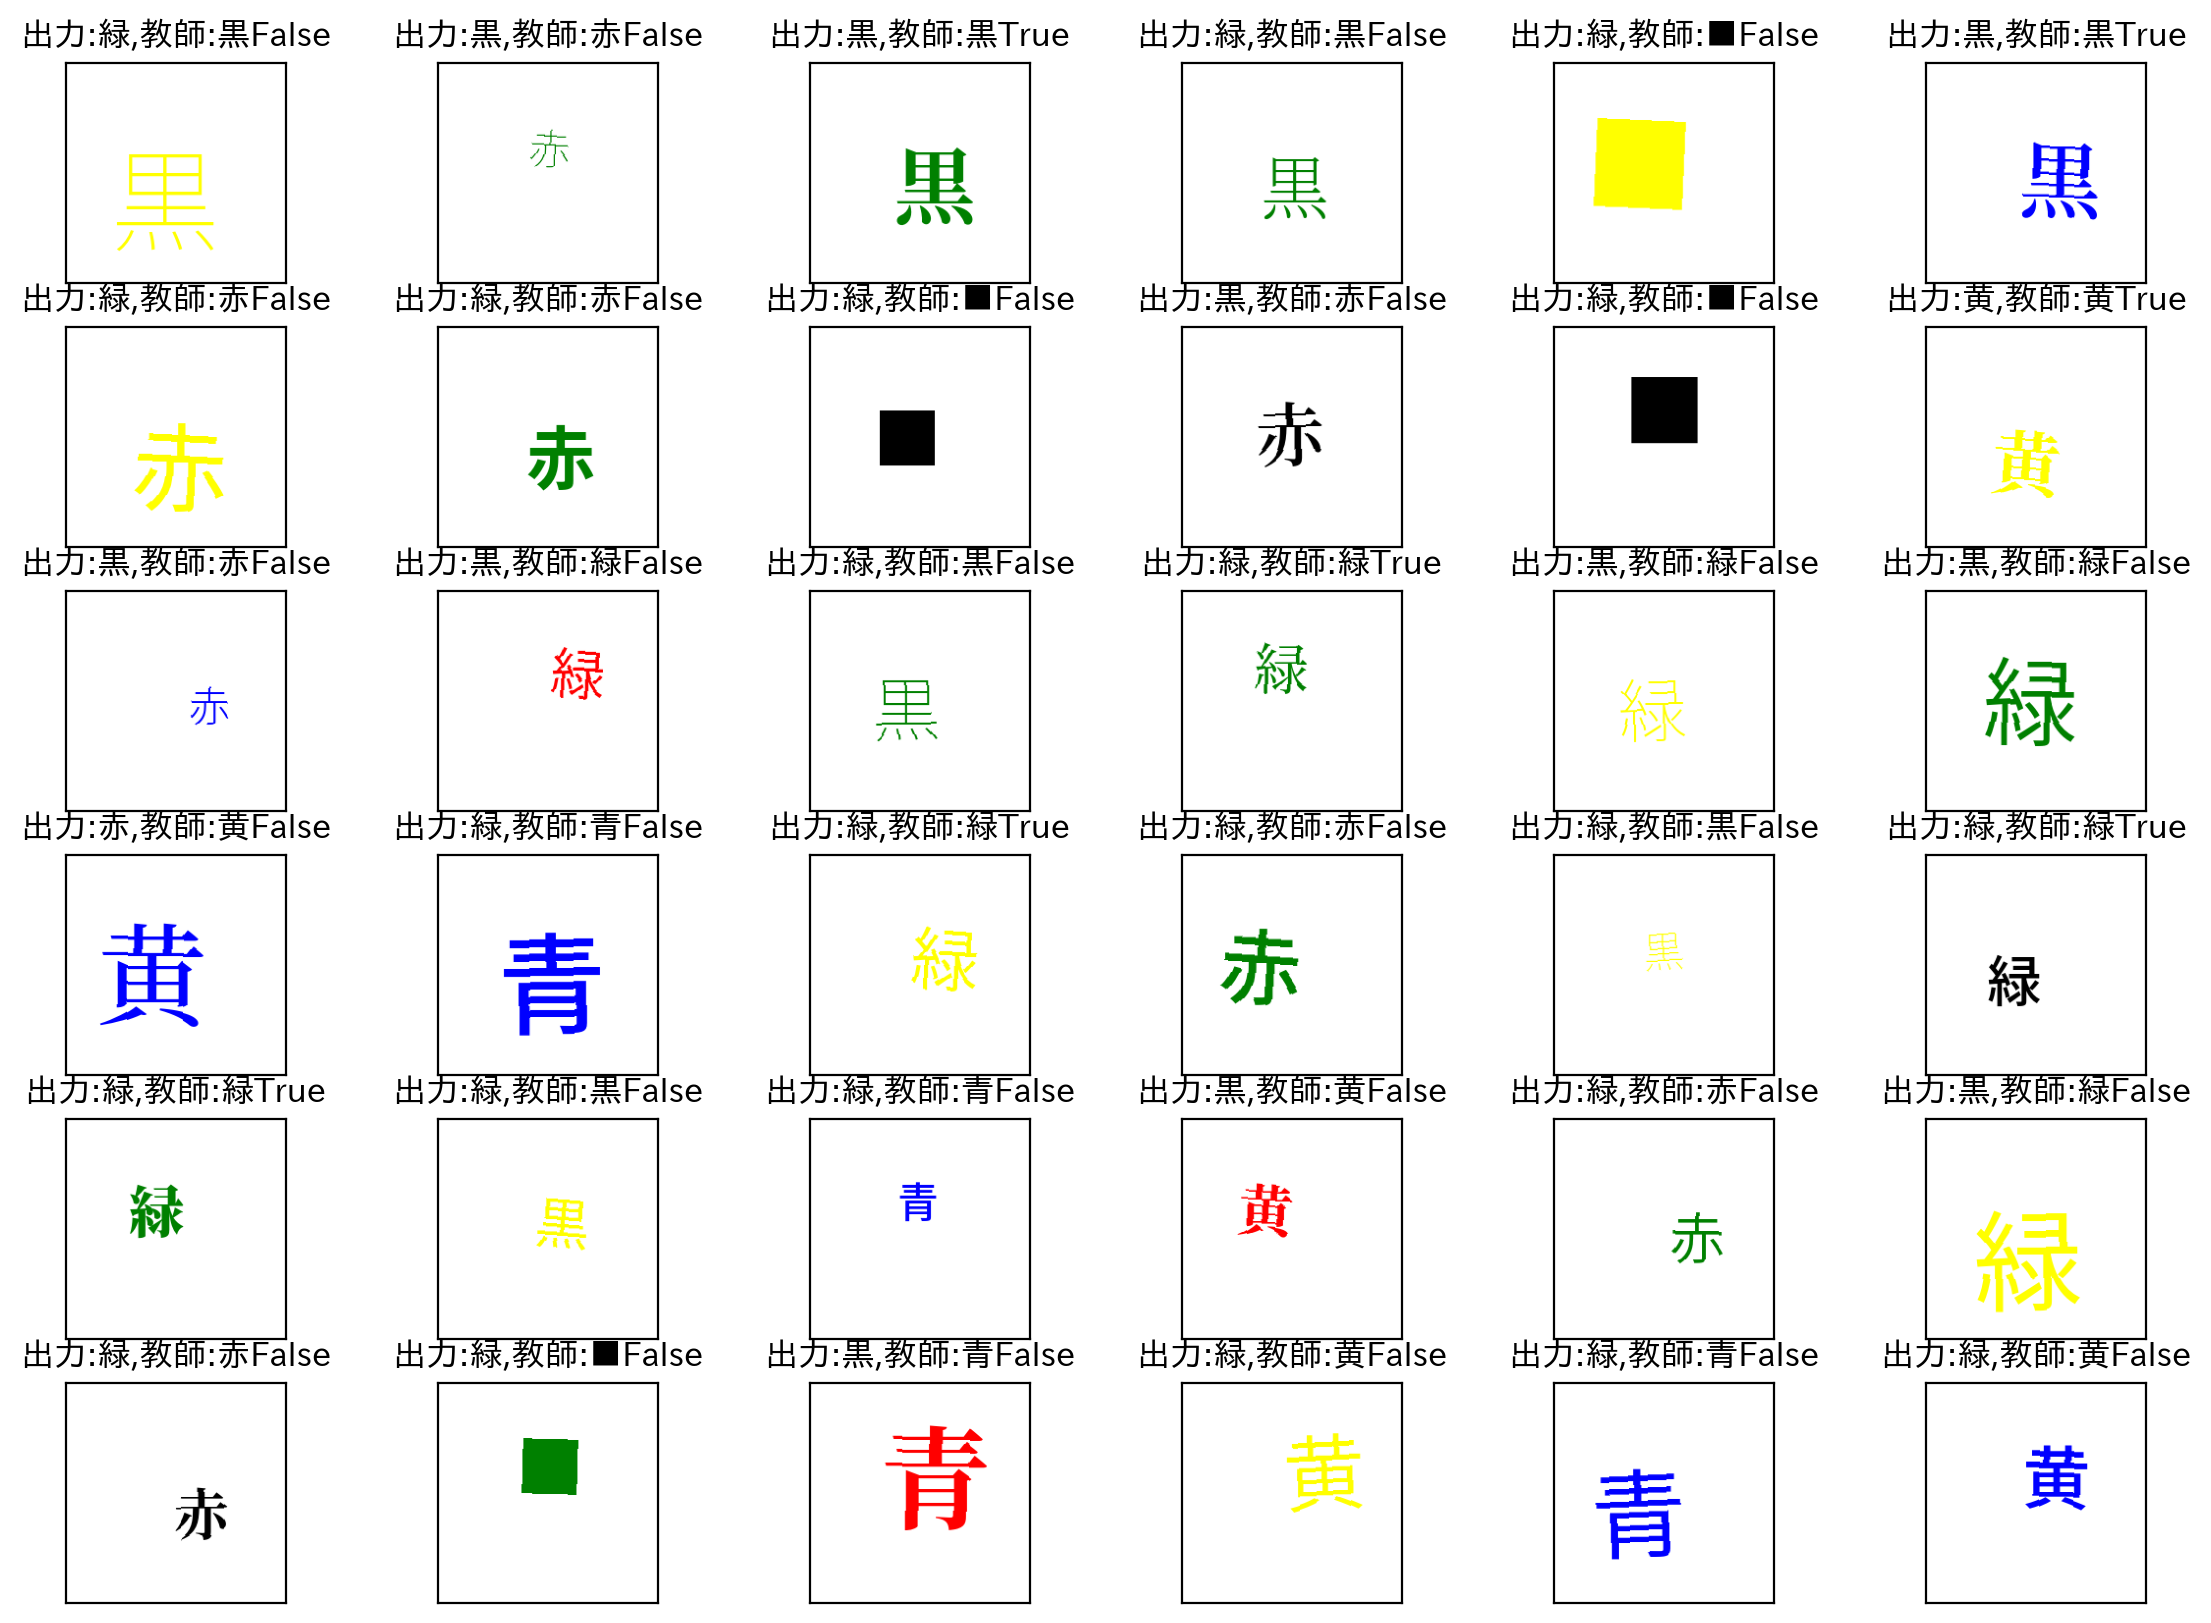

In [13]:
model = cnn_wrd
idx = 0
# img, y = ds.__getitem__(idx)
model.eval()

fig, ax = plt.subplots(6, 6, figsize=(14, 10))
i, j = 0, 0
j_max = 6

ds = stroop_ds # or stroop_val_ds
#ds = stroop_val_ds
Ns = np.random.permutation(ds.__len__())
for idx in Ns[:36]:
    img, y = ds.__getitem__(idx)
    output = model(img.unsqueeze(0))
    pred = output[0].topk(k=1)[1].cpu().numpy()[0]
    yesno = pred == y['word']
    print(i, j, ds.words[pred], ds.words[y['color']], yesno)
    #pred = ds.colors[output[0].topk(k=1)[0]]

    pred_str = ds.words[pred]
    tch_str = ds.words[y['word']]
    #color = 'red' if not yesno else 'grey'
    out_str = f'出力:{pred_str},教師:{tch_str}'

    _img = img.detach().squeeze(0).cpu().numpy().transpose(1,2,0) # * 255
    ax[i,j].title.set_text(out_str+str(yesno)) # :{ds.colors[y["word"]]}')
    ax[i,j].imshow(_img)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    j += 1
    if j == j_max:
        i+=1; j=0

#plt.show()

## 訓練済ファイルの読み込み

In [ ]:
# fc だけを保存して，model2 に再読み込み
#col_pt_fname = '2023_1113stroop_col_resnet50.pt'

col_pt_fname = '2023_1114stroop_col_resnet50_full.pt'
if os.path.exists(col_pt_fname):
    state_dict = torch.load(col_pt_fname)
    model_col = models.resnet50(weights="DEFAULT")
    model_col.fc = torch.nn.Linear(in_features=2048, out_features=len(stroop_ds.colors))
    model_col.load_state_dict(state_dict)

    #model_col.fc.weight = state_dict['fc.weight']
    #model_col.fc.bias = state_dict['fc.bias']
    #model_col.fc.weight.data = state_dict['fc.weight']
    #model_col.fc.bias.data = state_dict['fc.bias']

model_col.eval()
_ = _eval(target='color', model=model_col)

In [ ]:
import copy
#wrd_pt_fname = '2023_1113stroop_wrd_resnet50.pt'
wrd_pt_fname = '2023_1114stroop_wrd_resnet50_full.pt'
if os.path.exists(wrd_pt_fname):
    state_dict = torch.load(wrd_pt_fname)

    model_wrd = models.resnet50(weights="DEFAULT")
    model_wrd.fc = torch.nn.Linear(in_features=2048, out_features=len(stroop_ds.words))
    model_wrd.load_state_dict(state_dict)
    #mode_wrd = copy.deepcopy(cnn_wrd)

    #model_wrd.fc.load_state_dict(cnn_wrd.fc.state_dict())
    #model_wrd.fc.weight.data = state_dict['fc.weight']
    #model_wrd.fc.bias.data = state_dict['fc.bias']
    #model_wrd.load_state_dict(state_dict)
    #model_wrd.fc.bias.data = state_dict['fc.bias']
    #model_wrd.fc.weight.data = state_dict['fc.weight']
    model_wrd.eval()
    _eval(target='word', model=model_wrd)

In [14]:
# cnn_wrd = models.resnet50(weights="DEFAULT")
# cnn_wrd.fc = torch.nn.Linear(in_features=2048, out_features=len(stroop_ds.words))
# cnn_wrd.load_state_dict(model_wrd.state_dict())
# cnn_wrd.fc.load_state_dict(model_wrd.fc.state_dict())
# _eval(target='word', model=cnn_wrd)


def set_requires_grad_false(model):

    for name, param in model.named_parameters():
        param.requires_grad = False

    model.fc.bias.requires_grad = True
    model.fc.weight.requires_grad = True

    return model

m_col = models.resnet50(weights="DEFAULT")
m_col.fc = torch.nn.Linear(in_features=2048, out_features=len(stroop_ds.colors))
m_col = set_requires_grad_false(m_col)

# m_wrd = models.resnet50(weights="DEFAULT")
# m_wrd.fc = torch.nn.Linear(in_features=2048, out_features=len(stroop_ds.words))
# m_wrd = set_requires_grad_false(m_wrd)

for name, param in m_col.named_parameters():
    if param.requires_grad == True:
        print(name, param.size())

# for name, param in cnn_wrd.named_parameters():
#     param.requires_grad = False

# cnn_wrd.fc.bias.requires_grad = True
# cnn_wrd.fc.weight.requires_grad = True

# for name, param in cnn_wrd.named_parameters():
#     if param.requires_grad == True:
#         print(name, param.size())


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


fc.weight torch.Size([5, 2048])
fc.bias torch.Size([5])


## 訓練の実施

In [ ]:
#%%time
print('# 色名呼称課題')
_optimizer = torch.optim.Adam(params=params_to_update_col, lr=0.001)
#_optimizer = torch.optim.Adam(params=[cnn_col.classifier[1].bias, cnn_col.classifier[1].weight], lr=0.001)
#col_optimizer = torch.optim.Adam(params=params_to_update_col, lr=0.001)
losses_col = {'train':[], 'val':[]}
accs_col = {'train':[],'val':[]}
losses_col, accs_col = train_model(
    model=cnn_col,
    #model=cnn_col,
    target='color',
    optimizer=_optimizer,
    losses=losses_col,
    accs=accs_col,
    epochs=10)

# 色名呼称課題
エポック 01/10 val   損失: 1.6525 精度: 0.192 
エポック 02/10 train 損失: 1.1946 精度: 0.625 val   損失: 1.0604 精度: 0.783 
エポック 03/10 

In [ ]:
_eval(target='color', model=model_col, isDisplay=False)
#_eval(target='color', model=cnn_col, isDisplay=False)

In [ ]:
_eval(target='word', model=model_wrd, isDisplay=True)


In [ ]:
#cnn_wrd.eval()
#[(k, v) for k, v in cnn_wrd.named_parameters()]
#[type(p)  for p in cnn_wrd.parameters()]
#help(torch.optim.Adam)
for name, p in cnn_wrd.named_parameters():
    if 'layer4' in name:
        p.requires_grad = True
    elif 'fc' in name:
        p.requires_grad = True
    else:
        p.requires_grad = False
    print(name, p.requires_grad)


In [ ]:
print([p.requires_grad for p in cnn_wrd.parameters()])

In [ ]:
%%time
print('# 文字音読課題')
_optimizer = torch.optim.Adam(params=cnn_wrd.parameters(), lr=0.0001)
#_optimizer = torch.optim.Adam(params=[cnn_wrd.fc.bias, cnn_wrd.fc.weight], lr=0.001)
_losses = {'train':[], 'val':[]}
_accs = {'train':[],'val':[]}
losses_col, accs_col = train_model(
    model=cnn_wrd,
    target='word',
    optimizer=_optimizer,
    losses=_losses,
    accs=_accs,
    epochs=5)

In [ ]:
_optimizer = torch.optim.Adam(params=cnn_wrd.parameters(), lr=0.0001)
#_optimizer = torch.optim.Adam(params=[cnn_wrd.fc.bias, cnn_wrd.fc.weight], lr=0.0001)
#_optimizer = torch.optim.Adam(params=[cnn_wrd.fc.bias, cnn_wrd.fc.weight], lr=0.0001)
losses_col, accs_col = train_model(
    model=cnn_wrd,
    target='word',
    optimizer=_optimizer,
    losses=_losses,
    accs=_accs,
    epochs=10)
_eval(target='word', model=cnn_wrd, isDisplay=False)

In [ ]:
_eval(target='word', model=cnn_wrd, isDisplay=True)

In [ ]:
cnn_col

In [ ]:
import torchvision
from typing import Any, Callable, List, Mapping, Optional,  Set, Type,  Union
# # from typing import Any, Callable, Dict, Iterable, List, Mapping, Optional, Set, Type, TypeVar, Union
# # from typing import Any, Callable,                 List,          Optional,      Type,          Union
from torch import Tensor
from enum import Enum
from torchvision.models._utils import _ovewrite_named_param
from torchvision.utils import _log_api_usage_once

def conv3x3(in_planes: int,
            out_planes: int,
            stride: int = 1,
            groups: int = 1,
            dilation: int = 1) -> torch.nn.Conv2d:
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int,
            out_planes: int,
            stride: int = 1) -> torch.nn.Conv2d:
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class WeightsEnum(Enum):
    """
    This class is the parent class of all model weights.
    Each model building method receives an optional `weights` parameter with its associated pre-trained weights.
    It inherits from `Enum` and its values should be of type  `Weights`.

    Args:
        value (Weights): The data class entry with the weight information.
    """

    @classmethod
    def verify(cls, obj: Any) -> Any:
        if obj is not None:
            if type(obj) is str:
                obj = cls[obj.replace(cls.__name__ + ".", "")]
            elif not isinstance(obj, cls):
                raise TypeError(
                    f"Invalid Weight class provided; expected {cls.__name__} but received {obj.__class__.__name__}."
                )
        return obj

    def get_state_dict(self, *args: Any, **kwargs: Any) -> Mapping[str, Any]:
        return load_state_dict_from_url(self.url, *args, **kwargs)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}.{self._name_}"

    @property
    def url(self):
        return self.value.url

    @property
    def transforms(self):
        return self.value.transforms

    @property
    def meta(self):
        return self.value.meta


class _my_BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[torch.nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("_my_BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in _my_BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class _my_Bottleneck(torch.nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[torch.nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class _my_ResNet(torch.nn.Module):
    def __init__(
        self,
        block: Type[Union[_my_BasicBlock, _my_Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    torch.nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, _my_BasicBlock) and m.bn2.weight is not None:
                    torch.nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_layer(
        self,
        block: Type[Union[_my_BasicBlock, _my_Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> torch.nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return torch.nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def _my_resnet(
    block: Type[Union[_my_BasicBlock, _my_Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> _my_ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = _my_ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model

#@register_model()
#@handle_legacy_interface(weights=("pretrained", ResNet18_Weights.IMAGENET1K_V1))
def _my_resnet18(*, weights: Optional[torchvision.models.resnet.ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> _my_ResNet:
    """ResNet-18 from `Deep Residual Learning for Image Recognition <https://arxiv.org/abs/1512.03385>`__.

    Args:
        weights (:class:`~torchvision.models.ResNet18_Weights`, optional): The pretrained weights to use.
            See :class:`~torchvision.models.ResNet18_Weights` below for more details, and possible values.
            By default, no pre-trained weights are used.
        progress (bool, optional): If True, displays a progress bar of the download to stderr.
            Default is True.
        **kwargs: parameters passed to the ``torchvision.models.resnet.ResNet`` base class.
            Please refer to the `source code <https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py>`
            for more details about this class.

    .. autoclass:: torchvision.models.ResNet18_Weights
        :members:
    """
    weights = torchvision.models.ResNet18_Weights.verify(weights)

    return _my_resnet(_my_BasicBlock, [2, 2, 2, 2], weights, progress, **kwargs)


resnet18_org = torchvision.models.resnet18(weights='DEFAULT', progress=True)
resnet18_my_ = _my_resnet18(weights='DEFAULT')

#for k, v in resnet18_my_.named_parameters():
#    print(k, (eval(f'resnet18_my_.{k}')))

#for k, v in resnet18_org.state_dict().items():
resnet18_my_.load_state_dict(resnet18_org.state_dict())


<All keys matched successfully>

In [ ]:
_eval(target='color', model=cnn_col, isDisplay=True)

In [ ]:
%%time
print('-' * 77)
print('# 文字音読課題')
losses_wrd = {'train':[], 'val':[]}
accs_wrd = {'train':[],'val':[]}
wrd_optimizer = torch.optim.Adam(params=params_to_update_wrd, lr=0.0001)
#wrd_optimizer = torch.optim.Adam(params=params_to_update_wrd, lr=0.001)
losses_wrd, accs_wrd = train_model(
    model=cnn_wrd, target='word',
    optimizer=wrd_optimizer,
    losses=losses_wrd,
    accs=accs_wrd,
    #epochs=30)
    epochs=10)

In [ ]:
print(losses_col)  # 色名呼称条件の損失値の推移
#print(losses_wrd)  # 文字音読条件の損失値の推移
plt.plot(losses_col['train'],c='red', label='訓練データ')
plt.plot(losses_col['val'],c='blue', label='検証データ')
plt.title('色名呼称課題 損失値の変化')
plt.legend()
plt.show()

In [ ]:
plt.title('文字音読課題 損失値の変化')
plt.plot(losses_wrd['train'], label='訓練データ', c='red')
plt.plot(losses_wrd['val'], label='検証データ', c='blue')
plt.legend()
plt.show()

In [ ]:
outputs_col = _eval(target='color', model=cnn_col, isDisplay=True)
outputs_wrd = _eval(target='word', model=cnn_wrd, isDisplay=True)
print(outputs_wrd)
print(stroop_ds.words)

## 保存

In [ ]:
# 全体を保存して，model2 に再読み込み
_fname = '2023_1114stroop_col_resnet18.pt'
torch.save(cnn_col.state_dict(), _fname)
model3 = models.resnet18(weights="DEFAULT")
model3.fc = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.colors))
model3.load_state_dict(torch.load(_fname))
model3.eval()
_ = _eval(target='color', model=model3)

_fname = '2023_1114stroop_wrd_resnet18.pt'
torch.save(cnn_wrd.state_dict(), _fname)
model2 = models.resnet18(weights="DEFAULT")
model2.fc = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.words))
model2.load_state_dict(torch.load(_fname))
model2.eval()
_ = _eval(target='word', model=model2)


In [ ]:
cnn_wrd = copy.deepcopy(model2)
cnn_col = copy.deepcopy(model3)

In [ ]:
# fc だけを保存して，model2 に再読み込み
# _fname = '2023_1114stroop_col.pt'
# torch.save(cnn_col.fc.state_dict(), _fname)
# model2 = models.resnet50(weights="DEFAULT")
# model2.fc = torch.nn.Linear(in_features=2048, out_features=len(stroop_ds.colors))
# model2.fc.load_state_dict(torch.load(_fname))
# model2.eval()
# _ = _eval(target='color', model=model2)

_fname = '2023_1201stroop_wrd_tmp.pt'
torch.save(cnn_wrd.fc.state_dict(), _fname)   # fc 層だけ保存
model3 = models.resnet18(weights="DEFAULT")
model3.fc = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.words))
model3.fc.load_state_dict(torch.load(_fname))
model3.eval()
_ = _eval(target='word', model=model3)
_ = _eval(target='word', model=model2)
_ = _eval(target='word', model=cnn_wrd)

In [ ]:
type(cnn_col.state_dict()['fc.bias'])

In [ ]:
# #help(torch.save)
# weights_col = {'fc.weight': cnn_col.state_dict()['fc.weight'],
#                'fc.bias': cnn_col.state_dict()['fc.bias']}
# weights_wrd = {'fc.weight': cnn_wrd.state_dict()['fc.weight'],
#                'fc.bias': cnn_wrd.state_dict()['fc.bias']}
# torch.save(weights_col, '2023_1117stroop_col_fc.pt')
# torch.save(weights_wrd, '2023_1117stroop_wrd_fc.pt')

In [ ]:
def save_checkpoint(checkpoint_path, model): # , optimizer):
    state = {'state_dict': model.state_dict(),
             #'optimizer' : optimizer.state_dict()
            }
    torch.save(state, checkpoint_path)
    #print('model saved to %s' % checkpoint_path)

def load_checkpoint(checkpoint_path, model): # , optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    #optimizer.load_state_dict(state['optimizer'])
    #print('model loaded from %s' % checkpoint_path)

In [ ]:
model3 = models.resnet18(weights="DEFAULT")
model3.fc = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.colors))

save_checkpoint('2023_1113stroop_col.pt', cnn_col)
#model3.load_state_dict(torch.load(hoge_fname))
load_checkpoint('2023_1113stroop_col.pt', model3)
_ = _eval(target='color', model=cnn_col, isDisplay=False)
_ = _eval(target='color', model=model3, isDisplay=False)

# Stroop model の定義

## 最終直下層 penultimate layer の出力を保存するクラスの定義

In [ ]:
# モデルの指定された層の出力を存するクラス
class fetch_layer_output:
    def __init__(self,
                 model:torch.nn.Module,          # network to be fetch outputs
                 target_layer:torch.nn.Module):  # layer name in the network
        self.model = model
        self.layer_output = []

        # 特徴地図を取るため `register_forward_hook` を設定
        self.output_handle = target_layer.register_forward_hook(self.fetch_outputs)

    # self.output_handle の定義時に呼び出されるメソッド
    # モデルの指定された層ーの出力を保持
    def fetch_outputs(self, model, input, output):
         self.layer_output.append(output.to("cpu").detach())

    # メモリの解放を行うメソッド、フックを解除してメモリを解放する
    def release(self):
        self.output_handle.remove()

In [ ]:
fetch_wrd_penultimate_layer = fetch_layer_output(cnn_wrd, cnn_wrd.avgpool)
fetch_col_penultimate_layer = fetch_layer_output(cnn_col, cnn_col.avgpool)
#print(dir(fetch_wrd_penultimate_layer))
print(len(fetch_wrd_penultimate_layer.layer_output))

In [ ]:
inp, label = stroop_ds.__getitem__(0)
print(label)
print(type(inp), inp.size())
cnn_wrd.eval()
cnn_wrd(inp.unsqueeze(0))

In [ ]:
print(fetch_wrd_penultimate_layer.layer_output[0].shape)
#help(fetch_wrd_penultimate_layer)

In [ ]:
import copy

class stroop_model(torch.nn.Module):
    def __init__(self,
                 col_module:torch.nn.Module=cnn_col,
                 wrd_module:torch.nn.Module=cnn_wrd,
                 stroop_ds:torch.utils.data.dataset=stroop_ds,
                 n_hid_cond:int = 2,  # number of units in condition layer
                )-> None:

        super().__init__()

        # get the pretrained ResNet18 network
        self.bb = models.resnet18(weights="DEFAULT") # backbone

        # set all the parameters of sub modules are frozen
        for module in [col_module, wrd_module, bb]:
            for name, param in module.named_parameters():
                param.requires_grad = False

        # definition of psychological experiment conditions ['color naming'|'word reading']
        self.cond_layer = torch.nn.Embedding(num_embeddings=2, embedding_dim=n_hid_cond)

        self.col_layer = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.colors))
        self.wrd_layer = torch.nn.Linear(in_features=512, out_features=len(stroop_ds.words))

        n_in_features_out_layer = len(stroop_ds.colors) + len(stroop_ds.words) + self.cond_layer.out_features
        self.out_layer = torch.nn.Linear(
            in_features=n_in_features_out_layer,
            out_features=len(stroop_ds.colors))

    def set_condition(self, cond:str='color')-> None:
        if cond == 'color':
            self.cond_vec = self.cond_layer(torch.LongTensor([0]))
        elif cond == 'word':
            self.cond_vec = self.cond_layer(torch.LongTensor([1]))

    def forward(self,
                x:torch.Tensor) -> torch.Tensor:

        size = x.size(0)
        cond_vecs = self.cond_vec.repeat(size,1)

        x = self.cnn.conv1(x)
        x = self.cnn.bn1(x)
        x = self.cnn.relu(x)
        x = self.cnn.maxpool(x)

        x = self.cnn.layer1(x)
        x = self.cnn.layer2(x)
        x = self.cnn.layer3(x)
        x = self.cnn.layer4(x)

        x = self.cnn.avgpool(x)
        x = torch.flatten(x, 1)

        _col = self.col_layer(x)
        _wrd = self.wrd_layer(x)

        #x = self.out_layer(torch.cat((_col, _wrd, cond_vecs),dim=1))
        x = self.cnn.fc(x)

        return x

In [ ]:
model = stroop_model()
model.eval()
model.cnn.eval()
cond_vec = model.cond_layer(torch.LongTensor([1]))
model.set_condition(cond='color')
#print(cond_vec)
#print(f'model.cond_vec:{model.cond_vec}')
#sys.exit()
imgs, labels = next(iter(train_dl))

target='color'
imgs = torch.tensor(np.array([inp.detach().numpy() for inp in imgs])).to(device)
labels = torch.LongTensor([label[target] for label in labels])

#print(len(imgs))
out = model(imgs)
out.size()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
_optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# モデルを学習させる関数
def train_model2(
    model:torchvision.models=model,
    target:str='color',  # ['color', 'word']
    train_dl:torch.utils.data.dataloader=train_dl,
    val_dl:torch.utils.data.dataloader=val_dl,
    criterion:torch.nn.modules=criterion,
    optimizer:torch.optim=_optimizer,
    epochs:int=5,
    losses:dict=None,
    accs:list=None):

    if losses == None:
        losses = {'train':[], 'val':[]}
    if accs == None:
        accs = {'train':[],'val':[]}

    for epoch in range(epochs):

        # epochごとの学習と検証のループ
        for phase in [train_dl, val_dl]:
            if phase.name == 'train':
                model.train()  # モデルを訓練モードに
            else:
                model.eval()   # モデルを検証モードに

            epoch_loss = 0.     # epoch ごとの損失和
            epoch_corrects = 0  # epoch ごとの正解数

            # 未学習時の検証性能を確かめるため epoch=0 時の訓練は省略
            if (epoch == 0) and (phase.name == 'train'):
                continue

            # データローダからミニバッチを取り出すループ
            for inputs, labels in phase:
                inputs = torch.tensor(np.array([inp.detach().numpy() for inp in inputs])).to(device)
                labels = torch.LongTensor([label[target] for label in labels])

                optimizer.zero_grad() # optimizerを初期化
                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase.name =='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)   # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase.name == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch ごとの loss と正解率を表示
            N = train_ds.__len__() if phase.name == 'train' else val_ds.__len__()
            epoch_loss = epoch_loss / N
            epoch_acc = epoch_corrects.double() / N

            losses[phase.name].append(epoch_loss)
            accs[phase.name].append(epoch_acc.detach().numpy())  #[0])

            print(f'エポック {epoch+1:02d}/{epochs:02d}',
                  f'{phase.name:5s}',
                  f'損失: {epoch_loss:.4f}',
                  f'精度: {epoch_acc:.3f}')
    return losses, accs

train_model2()

In [ ]:
model.train()
img, label = stroop_ds.__getitem__(0)
out = model(img.unsqueeze(0))

tch = torch.LongTensor([label['color']]) # .unsqueeze(0)
print(out.size(), tch.size())
loss = criterion(out, tch)
loss.backward()
#tch
#torch.Tensor([label['color']])

In [ ]:
for i, (x, y) in enumerate(zip(cnn_col.state_dict().items(), cnn_wrd.state_dict().items())):
    if x[1].size() == y[1].size():
        yesno = np.sum((x[1] == y[1]).detach().numpy()) == x[1].detach().numpy().size
        if not yesno:
            print(i, x[0], y[0], yesno)
    else:
        print(colored((i, x[0],x[1].size(), y[1].size()), color='red', attrs=['bold']))

#    #print(i, k, np.array((cnn_col.state_dict()[k] == cnn_wrd.state_dict()[k]).detach().numpy()).sum())
#    #print(i, k, cnn_col.state_dict()[k].size())
print(cnn_col.state_dict()['fc.weight'].size())
print(cnn_wrd.state_dict()['fc.weight'].size())

In [ ]:
model = cnn_wrd
#model = cnn_col
target = 'word'
#target = 'color'
model.eval()

n_corrects = 0
Outs = []
for idx in tqdm(range(val_ds.__len__())):
#for idx in range(val_ds.__len__()):
    #_idx = np.random.choice(val_ds.__len__())
    _idx = idx
    img, label = val_ds.__getitem__(_idx)
    out = model(img.unsqueeze(0))
    _, pred = torch.max(out, 1)   # ラベルを予測
    _pred = pred.detach().numpy()[0]
    _tch = label[target]

    isOK = _pred == _tch
    if isOK:
        n_corrects += 1
    if not isOK:
        #print(isOK, _pred, _tch, stroop_ds.words[_tch])
        Outs.append({'idx':idx, '正否':isOK, '出力':_pred, '教師':_tch, '語':stroop_ds.words[_tch]})
        #plt.imshow(img.detach().numpy().transpose(1,2,0))

print(f'正解率: {(n_corrects / val_ds.__len__()) * 100:.3f} %')

#print(stroop_ds.words)
print(Outs)

In [ ]:
#val_ds.indices[0]
#val_ds.__getitem__(0)
print(f'{(n_corrects / val_ds.__len__()) * 100:.3f} %')
#print(f'{(1. - (n_corrects / val_ds.__len__())) * 100:.3f}')
